In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import sys
np.set_printoptions(suppress=True, threshold= sys.maxsize)

## Descriptive Analysis

Mode:
0. BUS
1. Train & Subway
2. Walk & Run
3. Car & Taxi & Motocycle
4. Airplane
5. Bike
6. Boat
100. Others

The issue in the data:
1. altitude range
2. mode number 100?

In [ ]:
%%script false 
import os
data =np.empty((1,1,6))
for path,directory,file in os.walk('numpyL/user'):  
    for name in file:
        user = np.load('numpyL/user/' + name)
        data = np.vstack((data, user))

Couldn't find program: 'false'


In [ ]:
user_1 = np.load("numpyL/labelled_user_1.npy")
data = pd.DataFrame(user_1, columns = ['user_id', 'latitude','longitude', 'altitude','timestamp', 'mode']).astype({'user_id':'int64', 'latitude':'float64','longitude':'float64', 'altitude':'float64','timestamp':'int64', 'mode':'int64'} )
assert sum(data['altitude'] == -777) == 0 # no missing value in altitude
data.describe()

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<span class="burk">Webmercator</span>


In [ ]:
data.dtypes

NameError: ignored

In [ ]:
data.head(5)

NameError: ignored

,user_id,time_left,time_right,mode
count,425.0,4.250000e+02,4.250000e+02,425.000000
mean,1.0,1.217278e+09,1.217282e+09,1.675294
std,0.0,3.696119e+06,3.696117e+06,8.375784
min,1.0,1.211269e+09,1.211270e+09,0.000000
25%,1.0,1.214369e+09,1.214369e+09,0.000000
50%,1.0,1.216710e+09,1.216711e+09,0.000000
75%,1.0,1.221018e+09,1.221021e+09,2.000000
max,1.0,1.223637e+09,1.223638e+09,100.000000


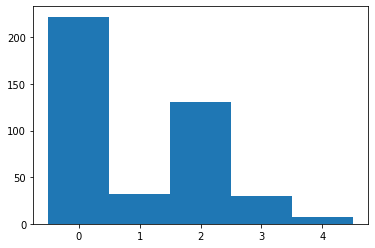

In [ ]:
label_1 = np.load("numpyL/labels4user_1.npy")
label = pd.DataFrame(label_1, columns = ['user_id', 'time_left','time_right', 'mode']).astype({'user_id':'int64', 'time_left':'int64','time_right':'int64', 'mode':'int64'})
plt.hist(label['mode'], bins = np.linspace(-0.5, 4.5,6))
plt.show
label.describe()

In [ ]:
label.head(10)

,user_id,time_left,time_right,mode
0,1,1211269140,1211270160,0
1,1,1211278500,1211279100,0
2,1,1211279100,1211285700,2
3,1,1211285700,1211286180,3
4,1,1211333040,1211333700,0
5,1,1211333700,1211347500,2
6,1,1211347560,1211348100,0
7,1,1211357400,1211358960,0
8,1,1211358960,1211361900,1
9,1,1211361900,1211366100,2


## Data Transformation

- Trip. if the time interval between two consecutive GPS points exceeds a pre-defined threshold
- Segement. if the mode changes in a trip

### Data Clean

- The GPS data points with the timestamp greater than their next GPS point are identified and discarded.
- Considering a maximum threshold speed for each transport mode, provided in Table 2, the invalid GPS points with an unrealistic large speed are discarded.
- Considering a maximum threshold acceleration for each transport mode, provided in Table 2, the invalid GPS points with an unrealistic large acceleration are discarded.
- After removing the unrealistic GPS points, the segments with the number of GPS points less than a threshold are identified and discarded.

We conduct the fist data cleaning.

#### split into trips
I first split the data into trips according to increasing monotony. This methods results in two side effects:
1. one trip contains multiple subtrip whose timestamp is increasing but the time gap is huge between certain records, i.e. merges two different trips into one.
2. can not show the timestamp outlier explicity.

But we can see what is going on.

In [ ]:
%%script false 
trips = []
i = 0
for j in range(1, data.shape[0]):
    if data['timestamp'][j] > data['timestamp'][j-1] :
        continue
    trips.append(data[i:j])
    i = j

Couldn't find program: 'false'


In [ ]:
%%script false 
for ind, val in enumerate(trips):
    print('num fo records:{:10d}\t timespan:{:10.3f} h'.format(len(val), (val['timestamp'].values[-1] - val['timestamp'].values[0])/3600), end = '\t')
    if ind > 0 :
        print('timespan (successive split):{:10.3f} h'.format((trips[ind]['timestamp'].values[0] - trips[ind-1]['timestamp'].values[-1])/3600))
    else:
        print()
    assert val['timestamp'].is_monotonic

Couldn't find program: 'false'


The first trip has 828 records, but the time span of these records are 1265 hours. Therefore, they are probably merged trips.

The number of records of each trip are all larger than 100, therefore, it might not be possible that there is a single outlier whose timestamp is quite abnormal compared with its former and latter record.

The time spans between two successive trip are always negative. It means that the trips are overlapped and unsorted.

#### split into segement

In [ ]:
%%script false 
segements = []
for trip in trips:
    i = 0
    for j in range(1, len(trip)):
        if trip['mode'].values[j] == trip['mode'].values[j-1]:
            continue
        segements.append(trip[i:j])
        i = j
print(len(segements))

Couldn't find program: 'false'


In [ ]:
%%script false 
segemets = sorted(segements, key = lambda x: x['timestamp'].values[0])

Couldn't find program: 'false'


In [ ]:
%%script false 
for ind, val in enumerate(segements):
    print('num fo records:{:10d}\t timespan:{:10.3f} h'.format(len(val), (val['timestamp'].values[-1] - val['timestamp'].values[0])/3600), end = '\t')
    if ind > 0 :
        print('timespan (successive split):{:10.3f} h'.format((segements[ind]['timestamp'].values[0] - segements[ind-1]['timestamp'].values[-1])/3600))
    else:
        print()

Couldn't find program: 'false'


#### what if sort by timestamp

In [ ]:
data_sorted = data.sort_values(by = 'timestamp', axis = 0,  ascending=True, inplace = False)

In [ ]:
assert data_sorted['timestamp'].is_monotonic_increasing == True

In [ ]:
trips = []
i = 0
for j in range(1,len(data_sorted)):
    if data_sorted['timestamp'][j]  - data_sorted['timestamp'][j-1] <= 10*60:
        continue
    trips.append(data_sorted[i:j])
    i = j
print(len(trips))

197


In [ ]:
segements = []
for trip in trips:
    i = 0
    for j in range(1, len(trip)):
        if trip['mode'].values[j] == trip['mode'].values[j-1]:
            continue
        segements.append(trip[i:j])
        i = j
print(len(segements))
for i in segements:
    assert i['mode'].nunique() == 1

208


#### calculate the speed, acceleration, jerk, bearing rate

speed, acceleration, jerk:

\begin{array}{l}{S_{p_{1}}=\frac{\text {Vincenty}\left(P_{1}, P_{2}\right)}{\Delta t}} \\ {A_{p_{1}}=\frac{S_{p_{2}}-S_{p_{1}}}{\Delta t}} \\ {J_{p_{1}}=\frac{A_{p_{2}}-A_{p_{1}}}{\Delta t}}\end{array}

Bearing Rate:

\begin{array}{l}{y=sine\left[p_{2}(\operatorname{long})-p_{1}(\operatorname{long})\right] * cosine\left[p_{2}(\operatorname{lat})\right]} \\ {x=cosine\left[p_{1}(\operatorname{lat})\right] * sine \left[p_{2}(\operatorname{lat})\right]- sine\left[p_{1}(\operatorname{lat})\right] * cosine\left[p_{2}(\operatorname{lat})\right] * cosine\left[p_{2}(\operatorname{long})-p_{1}(\operatorname{long})\right]} \\ {\operatorname{Bearing}_{\left(p_{1}\right)}=\arctan (y, x)} \\ {B R_{\left(p_{1}\right)}=\left|\operatorname{Bearing}_{\left(p_{2}\right)}-\operatorname{Bearing}_{\left(p_{1}\right)}\right|}\end{array}

![image.png](attachment:image.png)

In [ ]:
segements_4d = []
from geopy.distance import vincenty, geodesic
segements_4d = []
for segement in segements:
    segement_4d = pd.DataFrame(data = None, columns = ['distance','period','speed', 'acceleration', 'jerk', 'bearing_rate'], dtype = 'float64')
    for i in range(len(segement)-2):
        p1 = (np.radians(segement['latitude'].values[i]), np.radians(segement['longitude'].values[i]))
        p2 = (np.radians(segement['latitude'].values[i+1]), np.radians(segement['longitude'].values[i+1]))
        p3 = (np.radians(segement['latitude'].values[i+2]), np.radians(segement['longitude'].values[i+2]))
        dist = geodesic(p1, p2).meters
        #print(dist)
        t = segement['timestamp'].values[i+1] - segement['timestamp'].values[i]
        speed = dist / t
        acceleration = speed / t
        jerk = acceleration / t
        
        # Bearing Rate
        y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
        x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
        bearing_p1 = np.degrees(np.arctan2(y_1, x_1))
        
        y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
        x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
        bearing_p2 = np.degrees(np.arctan2(y_2, x_2))
        
        bearing_rate = np.abs(bearing_p2 - bearing_p1)

        mode = segement['mode'].values[i]
        segement_4d.loc[len(segement_4d)] = [dist, t, speed, acceleration, jerk, bearing_rate]
    segements_4d.append((segement_4d, segement['mode'].values[0]))

In [ ]:
for i in segements_4d:
    print(np.max(i[0]['period']))

2.0
3286.0
2.0
2.0
1272.0
9534.0
2.0
88.0
2.0
444.0
66355.0
2.0
2.0
1964.0
167713.0
1152.0
2.0
3886.0
112.0
1296.0
2.0
234.0
150.0
4330.0
98.0
4484.0
2.0
104.0
2.0
1448.0
58221.0
500.0
180.0
116.0
1064.0
104.0
4966.0
49104.0
6352.0
2.0
2.0
2.0
278.0
72289.0
88.0
138856.0
420.0
22.0
4918.0
81079.0
2192.0
96124.0
5.0
5.0
5.0
1811.0
235339.0
1370.0
410.0
1045.0
19104.0
380.0
1055.0
5.0
6921.0
10.0
265.0
5.0
5.0
270.0
113928.0
800.0
5.0
640.0
6645.0
15.0
5.0
152779.0
15.0
5878.0
880.0
595.0
5.0
10.0
nan
205.0
82774.0
5.0
64404.0
3860.0
5.0
5.0
25.0
5.0
4915.0
25.0
108237.0
10.0
285.0
325.0
5.0
360.0
11060.0
nan
50.0
460.0
32213.0
8000.0
43608.0
1475.0
4020.0
1205.0
5.0
5.0
5.0
405.0
5.0
135.0
5.0
985.0
15.0
1135.0
80.0
3540.0
13277.0
2210.0
1380.0
5.0
5.0
865.0
80141.0
5.0
5.0
12500.0
5.0
5.0
5.0
5.0
500.0
910.0
5.0
550.0
61838.0
1310.0
1415.0
10365.0
205.0
1395.0
5.0
5.0
5.0
5.0
450.0
5.0
110.0
100.0
385.0
5.0
2395.0
5.0
5.0
360.0
4557.0
50.0
nan
25.0
5.0
515.0
2285.0
54120.0
9176.0
5.0
3

In [ ]:
print(segements_4d[6][1])
segements_4d[6][0].describe()

1


,distance,period,speed,acceleration,jerk,bearing_rate
count,15.000000,15.0,15.000000,15.000000,15.000000,1.500000e+01
mean,0.016045,2.0,0.008023,0.004011,0.002006,5.327608e+01
std,0.013876,0.0,0.006938,0.003469,0.001735,7.341828e+01
min,0.000000,2.0,0.000000,0.000000,0.000000,2.616282e-07
25%,0.006624,2.0,0.003312,0.001656,0.000828,8.336996e+00
50%,0.009714,2.0,0.004857,0.002428,0.001214,1.323696e+01
75%,0.029534,2.0,0.014767,0.007384,0.003692,7.740672e+01
max,0.044119,2.0,0.022059,0.011030,0.005515,2.503253e+02


#### maxium speed,acceleration thresthold

![image.png](attachment:image.png)

#### number of records threshold: 200

In [ ]:
segements_4d = [x for x in segements_4d if len(x[0]) >= 200]  # remove segements less than 250 records
data_4d = []
for segement_4d in segements_4d:
    i = 0
    for j in range(1, len(segement_4d[0])):
        if j % 200 == 0:                                    # 250 records per segement
            data_4d.append((segement_4d[0][i:j], segement_4d[1])) 
            i = j
for i in data_4d:
    assert len(i[0]) == 200

###  Data Preparation


As we have tested the data clean on one user, the result is correct and reliable. Therefore I will use `numpy.ndarray` to scale above process to large number of users.

In [ ]:
import os
from geopy.distance import vincenty, geodesic
x = [] #np.empty((1, 1, 200, 4)) # (segements, width, length, channel)
y = []#np.empty((1))
for path,directory,file in os.walk('numpyL/user'): 
    for ind, filename in enumerate(file):
        # sort by timestamp
        user_data = np.load('numpyL/user/' + filename) # shape (row, col)
        user_data_sorted = user_data[user_data[:,4].argsort()]
        #assert user_data_sorted[:,4].is_monotonic_increasing == True

        # split into trips
        trips = [] # (trip, row, col)
        i = 0
        for j in range(1,len(user_data_sorted)):
            if user_data_sorted[j,4] - user_data_sorted[j-1,4] <= 600:
                continue
            trips.append(user_data_sorted[i:j,:])
            i = j
        segements = [] #np.empty((1,1,6)) # (segement, row, col)
        for trip in trips:
            i = 0
            for j in range(1, len(trip)):
                if trip[j,5] == trip[j-1,5]:
                    continue
                segements.append(trip[i:j,:])
                i = j
        
        # calculate channel data
        segements_4d = []#np.empty((1,1,4))
        target = []#np.empty((1))
        for segement in segements:
            segement_4d = np.empty((1,4))
            for i in range(len(segement)-2):
                p1 = (np.radians(segement[i,1]), np.radians(segement[i,2]))
                p2 = (np.radians(segement[i+1,1]), np.radians(segement[i+1,2]))
                p3 = (np.radians(segement[i+2,1]), np.radians(segement[i+2,2]))
                dist = geodesic(p1, p2).meters
                #print(dist)
                t = segement[i+1,4] - segement[i,4]
                if t == 0:
                    continue
                speed = dist / t
                acceleration = speed / t
                jerk = acceleration / t

                # Bearing Rate
                y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
                x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
                bearing_p1 = np.degrees(np.arctan2(y_1, x_1))

                y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
                x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
                bearing_p2 = np.degrees(np.arctan2(y_2, x_2))

                bearing_rate = np.abs(bearing_p2 - bearing_p1)

                mode = segement[i,5]
                segement_4d = np.concatenate((segement_4d,np.array([speed, acceleration, jerk, bearing_rate]).reshape((1,4))))
            segements_4d.append(segement_4d)
            target.append(segement[0,5])
        
        # split into 200 per segement
        segements_4d_200 = [i for i in segements_4d if len(i) >= 200]  # remove segements less than 250 records

        for ind, segement_4d in enumerate(segements_4d_200):
            i = 0
            for j in range(1, len(segement_4d)):
                if j % 200 == 0:                                    # 200 records per segement
                    x.append(segement_4d[i:j,:])
                    y.append(target[ind])
                    i = j

In [ ]:
print(len(x), len(y))

706 706
